In [1]:
# check versions and devices
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
print("python version: ", sys.version)
# print("tf version: ", tf.__version__)
# print("devices: ", tf.config.list_physical_devices())

2022-11-18 15:11:11.698394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


python version:  3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]


In [2]:
# create train and validation datasets
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    shuffle=True
)

train_ds.class_names

Found 16041 files belonging to 2 classes.
Using 12833 files for training.
Metal device set to: AMD Radeon Pro 560X

systemMemory: 32.00 GB
maxCacheSize: 2.00 GB

Found 16041 files belonging to 2 classes.
Using 3208 files for validation.


['car', 'not_car']

In [3]:
# configure performance
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [4]:
# model -> fine tuning pre-trained model imported from CNN-1.6 by Mario Peng Lee
model = tf.keras.Sequential([
  # input layer: dynamic input size
  tf.keras.layers.InputLayer(input_shape=(None, None, 3)),
  # resize images to 180x180
  tf.keras.layers.Resizing(180, 180, interpolation="bicubic"),
  # rescaling to 0-1
  tf.keras.layers.Rescaling(1./255),
  # hidden layers: conv2D + maxpooling (note: batchnorm not used as destroys validation accuracy)
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # flatten and dense layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  # output layer
  tf.keras.layers.Dense(2)
])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

In [5]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [6]:
# train
import tensorflow as tf
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
101/101 [==============================] - 63s 604ms/step - loss: 0.4037 - accuracy: 0.8139 - val_loss: 0.2461 - val_accuracy: 0.9043
Epoch 2/3
101/101 [==============================] - 55s 549ms/step - loss: 0.2178 - accuracy: 0.9138 - val_loss: 0.1762 - val_accuracy: 0.9333
Epoch 3/3
101/101 [==============================] - 55s 543ms/step - loss: 0.1694 - accuracy: 0.9358 - val_loss: 0.1510 - val_accuracy: 0.9476


In [7]:
# save model
import pandas as pd

model.save('model.h5')
hist_df = pd.DataFrame(history.history)
with open("hist.json", "w") as f:
    hist_df.to_json(f)


In [8]:
# load
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow_hub import KerasLayer
import pandas as pd

model = load_model('model.h5')
model_hist = pd.read_json("hist.json")

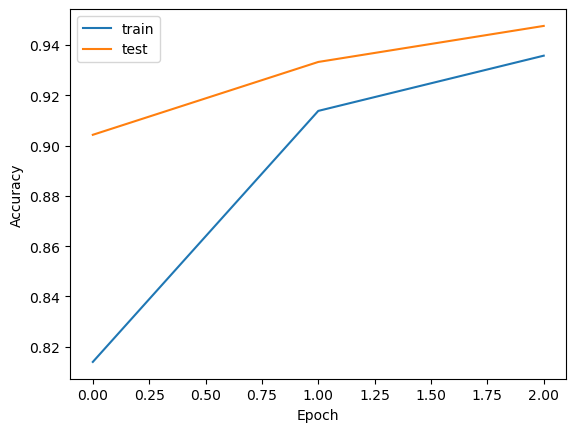

In [9]:
# plot accuracy and val_accuracy
import matplotlib.pyplot as plt
plt.plot(model_hist['accuracy'], label='train')
plt.plot(model_hist['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

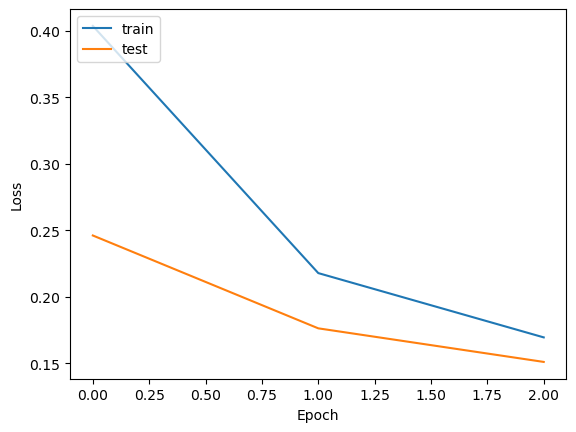

In [10]:
# plot loss and val_loss
plt.plot(model_hist['loss'], label='train')
plt.plot(model_hist['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()